# Data Science

## Notebook 4 (Character recognition with Keras)

### Character recoginition with Keras

(Thanks to Róbert Pálovics and József Pintér)

In [1]:
# imports for plotting and displaying the data
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from PIL import ImageOps
import numpy as np
from matplotlib.pyplot import imshow
sns.set(font="Droid Sans",font_scale = 1)
sns.set_style("white")
sns.set_color_codes("dark")

#### MNIST Dataset
* 70,000 pictures of handwritten digits 
* 28x28 pixel grayscale images, so there are 28x28 = 784 attributes each with values 0-255
* <span style="color:red">How many attributes would there be for a 28X28 RGB image?</span>
* Possible labels: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 (multi-class classifcation)

In [13]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test.shape

(10000, 28, 28)

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
a = x_train[0]

for line in a:
    print ('  '.join(map(str, line)))

0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  0  0  0  3  18  18  18  126  136  175  26  166  255  247  127  0  0  0  0
0  0  0  0  0  0  0  0  30  36  94  154  170  253  253  253  253  253  225  172  253  242  195  64  0  0  0  0
0  0  0  0  0  0  0  49  238  253  253  253  253  253  253  253  253  251  93  82  82  56  39  0  0  0  0  0
0  0  0  0  0  0  0  18  219  253  253  253  253  253  198  182  247  241  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  80  156  107  253  253  205  11  0  43  154  0  0  0  0  0  0  0  0  0  0
0  0  0  0  0  0  0  0  0  14  1  154  253  90  0  0  0  0  0 

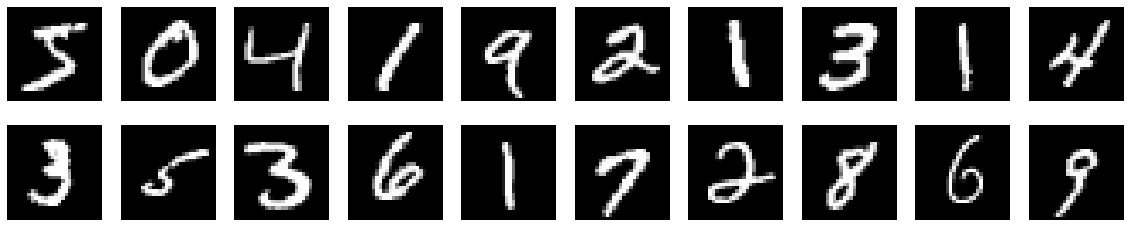

In [5]:
plt.figure(figsize=(20,4))
for i in range(20):
  plt.subplot(2,10,i+1)
  plt.axis('off')
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

In [6]:
y_train[0:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

#### Reformatting the data
- Values between 0-1
- Tensorflow takes in 4d data: the number of records, the height of the image, the width of the image, the number of channels (1 for grayscale images, 3 for RGB images). Use the -1 parameter for the number of records because it is dynamic.
- Make sure data is all of the same type
- Change label values 0-9 to len=10 arrays, <span style="color:red">why?</span>

In [18]:
# rescale the data to numbers between 0-1, by convention and to improve training efficiency
x_train = x_train / 255
x_test = x_test / 255

# store the pictures in an appropriate tensor 28x28 pictures with only 1 channel 
# the -1 parameter indicates keras should infer the shape of the matrix (in this case 60000)
x_train = x_train.reshape(-1,28,28,1) 
x_test = x_test.reshape(-1,28,28,1)
# tensorflow will not perform the necessary operations if data is stored as different types
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")


# change target variable to categorical attribute (one-hot-encoding):
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [19]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [20]:
a = np.round(x_train[0],decimals=1)
p = ""
for line in a:
    for i in range(0,len(line)):
        p += str(int(line[i][0]))#; p += ""
    print(p); p = ""

0000000000000000000000000000
0000000000000000000000000000
0000000000000000000000000000
0000000000000000000000000000
0000000000000000000000000000
0000000000000000000001100000
0000000000000111110010000000
0000000001111111110000000000
0000000001111100100000000000
0000000000011000000000000000
0000000000001000000000000000
0000000000001000000000000000
0000000000000100000000000000
0000000000000000000000000000
0000000000000001100000000000
0000000000000000110000000000
0000000000000000011000000000
0000000000000000011100000000
0000000000000000011000000000
0000000000000001111000000000
0000000000000111100000000000
0000000000011110000000000000
0000000001111000000000000000
0000000111110000000000000000
0000011100000000000000000000
0000000000000000000000000000
0000000000000000000000000000
0000000000000000000000000000


 #### Modeling

We are going to build the following model:

|                 | filters | filter_size/pool_size | activation | channel dimention
| --------------- | :-----------: | :--------------------: | :--------: | :--------:
| Conv2D          |      32       |          5x5           |    relu    |    24
| Conv2D          |      64       |          5x5           |    relu    |    ?
| MaxPooling2D    |       -       |          2x2           |     -     |     ?
| Flatten()       |       -       |           -            |     -      |    -
| Dense (output) |       ?       |           -            | 'softmax'  |     -

#### Convolutional (feature mapping) layer
Terminology: stride length, kernel/filter size, channels

Function: w1 * in1 + w2 * in2 + w3 * in3 + w4 * in4 + b

![CNN_feature_mapping.webp](attachment:CNN_feature_mapping.webp)

#### Pooling (down sampling) layer
Terminology: padding

Function: max()

![CNN_pooling.webp](attachment:CNN_pooling.webp)

#### Flatten
The output of the covolution and pooling layers contain new high-level data features which describe the input image rather than the low-level pixel data we started with. These need to be "flattened" into a vector which becomes the input into the last fully-connected or "dense" layer of the CNN - like tagging a simple neural network classifier onto the end.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Keras Sequential models can be constructed layer by layer. 

In [32]:
#Initialize the Sequential model:
model = Sequential() 

#Add a 2D convolutional layer: params (in order): number of filters, size of the kernel, the others are written there.
model.add(Conv2D(32, (5, 5), strides=(1, 1), input_shape=(28, 28, 1), activation='softmax', data_format="channels_last")) 

#Another 2D convolutional layer: declaring the input shape is only necessary for the first layer
model.add(Conv2D(64, (5, 5), activation='softmax'))

#Add a 2x2 MaxPool layer: how big will the outputs be?
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Flatten the output, because the next layer will be a Dense (Fully Connected) layer, which accepts 1 dimensional inputs.
model.add(Flatten())

#Another Dense layer: Why do we use 10 output units? 
model.add(Dense(10, activation='relu'))

#Compiling the model, loss: categorical crossentropy, it is the most popular for these kind of problems,
#optimizer: adam, a faster variant of the stochastic gradient method
#metrics: accuracy (We want to know the accuracy after each epoch.)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
#We want to stop the training process, if the loss on the validation set did not improve since 10 epochs.
early_stopping=EarlyStopping(patience=10, verbose=1)

#We do not want to store the weights of the model after the last epoch, we want the weights of the best model!
#We will store those weights in a file weights.hdf5
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

#We call the fit method with 100 epochs, 128 batch_size, and 0.2 validation split. 
#We have to specify which callbacks or 'plugins' we want to use.
network_history = model.fit(x_train, y_train, batch_size=128, 
                            epochs=100, verbose=1, validation_split=0.2,
                  callbacks=[checkpointer, early_stopping])

Epoch 1/100
372/375 [============================>.] - ETA: 0s - loss: 10.2247 - accuracy: 0.1091
Epoch 1: val_loss improved from inf to 10.20576, saving model to weights.hdf5
375/375 [==============================] - 4s 10ms/step - loss: 10.2232 - accuracy: 0.1105 - val_loss: 10.2058 - val_accuracy: 0.2606
Epoch 2/100
374/375 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.1260
Epoch 2: val_loss did not improve from 10.20576
375/375 [==============================] - 4s 10ms/step - loss: nan - accuracy: 0.1260 - val_loss: nan - val_accuracy: 0.0995
Epoch 3/100
369/375 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0990
Epoch 3: val_loss did not improve from 10.20576
375/375 [==============================] - 4s 10ms/step - loss: nan - accuracy: 0.0985 - val_loss: nan - val_accuracy: 0.0995
Epoch 4/100
374/375 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0985
Epoch 4: val_loss did not improve from 10.20576
375/375 [===

Before we can evaluate the results, we have to load the weights of the best model!

In [24]:
from keras.models import load_model
model = load_model("weights.hdf5")
test_err = model.evaluate(x_test,y_test)
print("Loss on test set:", test_err[0], "Accuracy on test set:", test_err[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0329 - accuracy: 0.9887
Loss on test set: 0.03292933106422424 Accuracy on test set: 0.9886999726295471


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,1)
y_true = np.argmax(y_test,1)

print("Test accuracy: %g" %(accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro")) #one vs rest averages or global
print("Recall", recall_score(y_true, y_pred, average="macro")) #macro calculates the average of the recall for each class
print("f1_score", f1_score(y_true, y_pred, average="macro")) #macro is good for balanced data set, micro is good for imbalanced
print("\n Confusion matrix ")
conf=confusion_matrix(y_true, y_pred)
print(conf)

313/313 [==============================] - 1s 2ms/step
Test accuracy: 0.9887
Precision 0.9885816556704237
Recall 0.9888599519566796
f1_score 0.988697754288968

 Confusion matrix 
[[ 972    0    1    0    0    0    2    3    2    0]
 [   1 1113    2    5    0    0    6    0    8    0]
 [   1    0 1023    0    1    0    0    4    3    0]
 [   0    0    1  998    0    5    0    3    3    0]
 [   0    0    0    0  980    0    0    0    1    1]
 [   1    0    0    4    0  885    1    1    0    0]
 [   5    2    0    1    1    3  944    0    2    0]
 [   0    1    5    1    0    0    0 1018    1    2]
 [   2    0    2    1    0    1    0    0  966    2]
 [   1    0    1    0    4    6    0    8    1  988]]


We should also plot the confusion matrix as a heatmap!

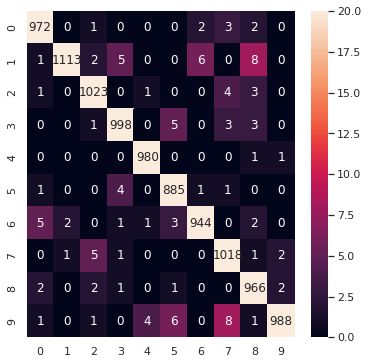

In [26]:
plt.figure(figsize=(6,6))
sns.heatmap(conf, annot=True, fmt='d', vmax=20)
plt.show()

I tried a bunch of different parameters for the models and below are the results:

Activtation functions: sigmoid, softmax, optimizer = SGD:
- loss: 0.0838, accuracy: 0.9765

Activtation functions: sigmoid, relu, optimizer = Adam:
- loss: 0.0128, accuracy: 0.9387

Activtation functions: softmax, relu, optimizer = SGD:
- loss: 0.0900, accuracy: 0.9818

Activtation functions: relu, sigmoid, optimizer = Adam:
- loss: 5.7533e-04, accuracy: 1.0000

Clearly, the best accuracy as well as least loss was given by the 2 activtation functions: relu, sigmoid, optimizer = Adam

PART B


### Testing on own handwritten digits

In [31]:
sns.set(font_scale = 2)
# visualizing hand-written digits
thresholds = {}
thresholds[ 0 ] = ( 225 , 229 , 451 , 458 )
thresholds[ 1 ] = ( 675 , 229 , 901 , 458 )
thresholds[ 2 ] = ( 1126 , 229 , 1352 , 458 )
thresholds[ 3 ] = ( 1576 , 229 , 1802 , 458 )
thresholds[ 4 ] = ( 2027 , 229 , 2253 , 458 )
thresholds[ 5 ] = ( 225 , 687 , 451 , 916 )
thresholds[ 6 ] = ( 675 , 687 , 901 , 916 )
thresholds[ 7 ] = ( 1126 , 687 , 1352 , 916 )
thresholds[ 8 ] = ( 1576 , 687 , 1802 , 916 )
thresholds[ 9 ] = ( 2027 , 687 , 2253 , 916 )

plt.figure( figsize = ( 50 , 10 ) )
for i in range( 10 ):
    image = Image.open("./myhandwritten_digits.jpg")
    width, height = image.size
    image = image.crop( thresholds[ i ] )
    image = ImageOps.invert( image )
    image.thumbnail( ( 28 , 28 ) )
    image_data = np.asarray( image , dtype = np.uint8 )
    image_data = image_data.sum( 2 ).astype( float )
    image_data /= image_data.max()
    plt.subplot( 2 , 5 , i + 1 )
    plt.imshow( image_data, cmap = plt.cm.gray )

UnidentifiedImageError: ignored

<Figure size 3600x720 with 0 Axes>

In [29]:
# using the trained model to recognize hand-written digits
plt.figure( figsize = ( 40 , 12 ) )
for i in range( 10 ):
    image = Image.open( "./myhandwritten_digits.jpg")
    width, height = image.size
    image = image.crop( thresholds[ i ] )
    image = ImageOps.invert( image )
    image.thumbnail( ( 28 , 28 ) )
    image_data = np.asarray( image , dtype = np.uint8 )
    image_data = image_data.sum( 2 ).astype( float )
    image_data /= image_data.max()
    image_data = image_data.reshape( -1 , 28 , 28 , 1 )
    predictions = model.predict( image_data > 0.8 )
    plt.subplot( 2 , 5 , i + 1 )
    plt.bar( range( 10 ) , predictions[ 0 ] , 0.3 , color = "b" , alpha = 0.6 )
    plt.title( i )
    plt.grid()
    plt.xticks( range( 10 ) )

UnidentifiedImageError: ignored

<Figure size 2880x864 with 0 Axes>

In [30]:
# The model was able to recognize my handwriting to a good extent! It wasn't perfect but quite good.

### Visualize the output of the 2D convolutional layers.

In [ ]:
from keras.models import Model

# we will look at just the first two (convolutional) layers of our model
layer_outputs = [layer.output for layer in model.layers[0:2]]
activation_model = Model(inputs=model.input,outputs=layer_outputs)

In [ ]:
# first 4 pictures in the test set:
img = x_test[0:4].reshape(-1,28,28,1)
# with labels: 7,2,1,0
np.argmax(y_test[0:4],axis=1)

array([7, 2, 1, 0])

1/1 [==============================] - 0s 83ms/step


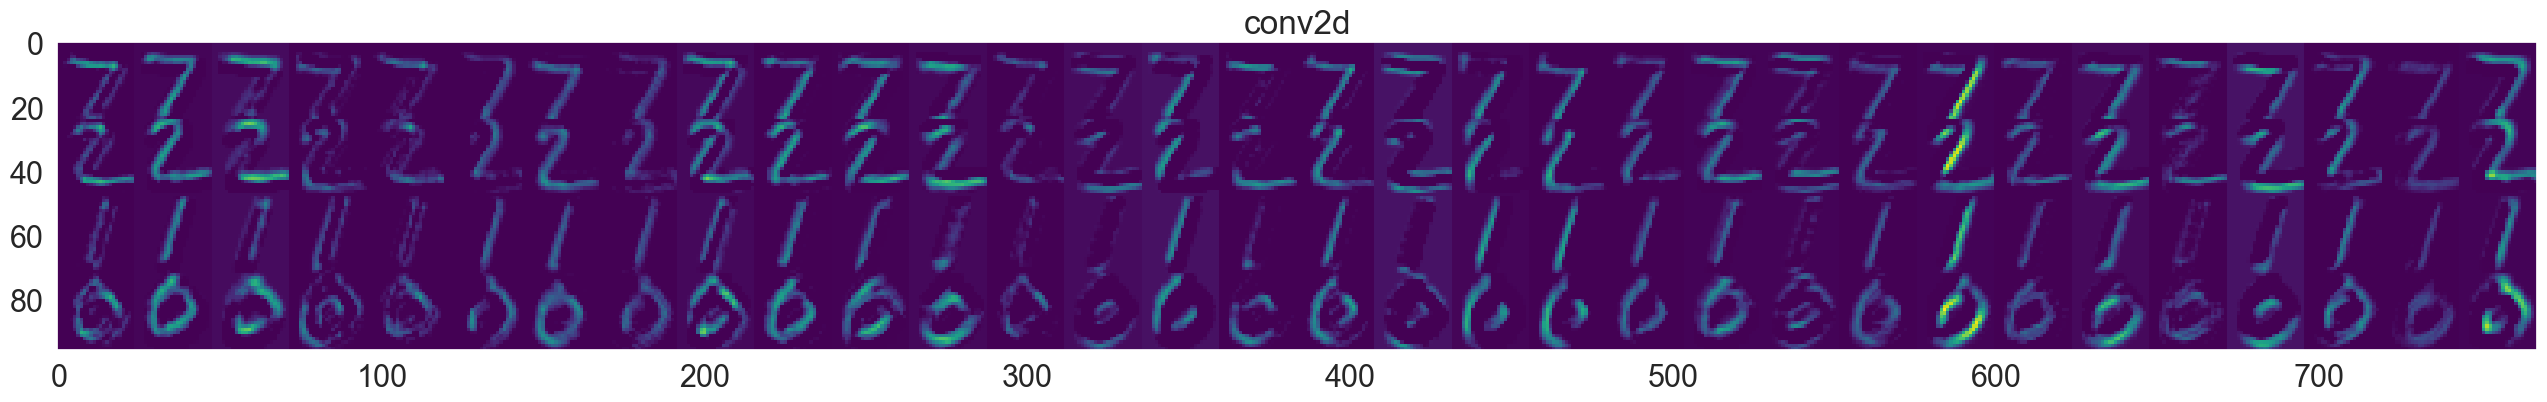

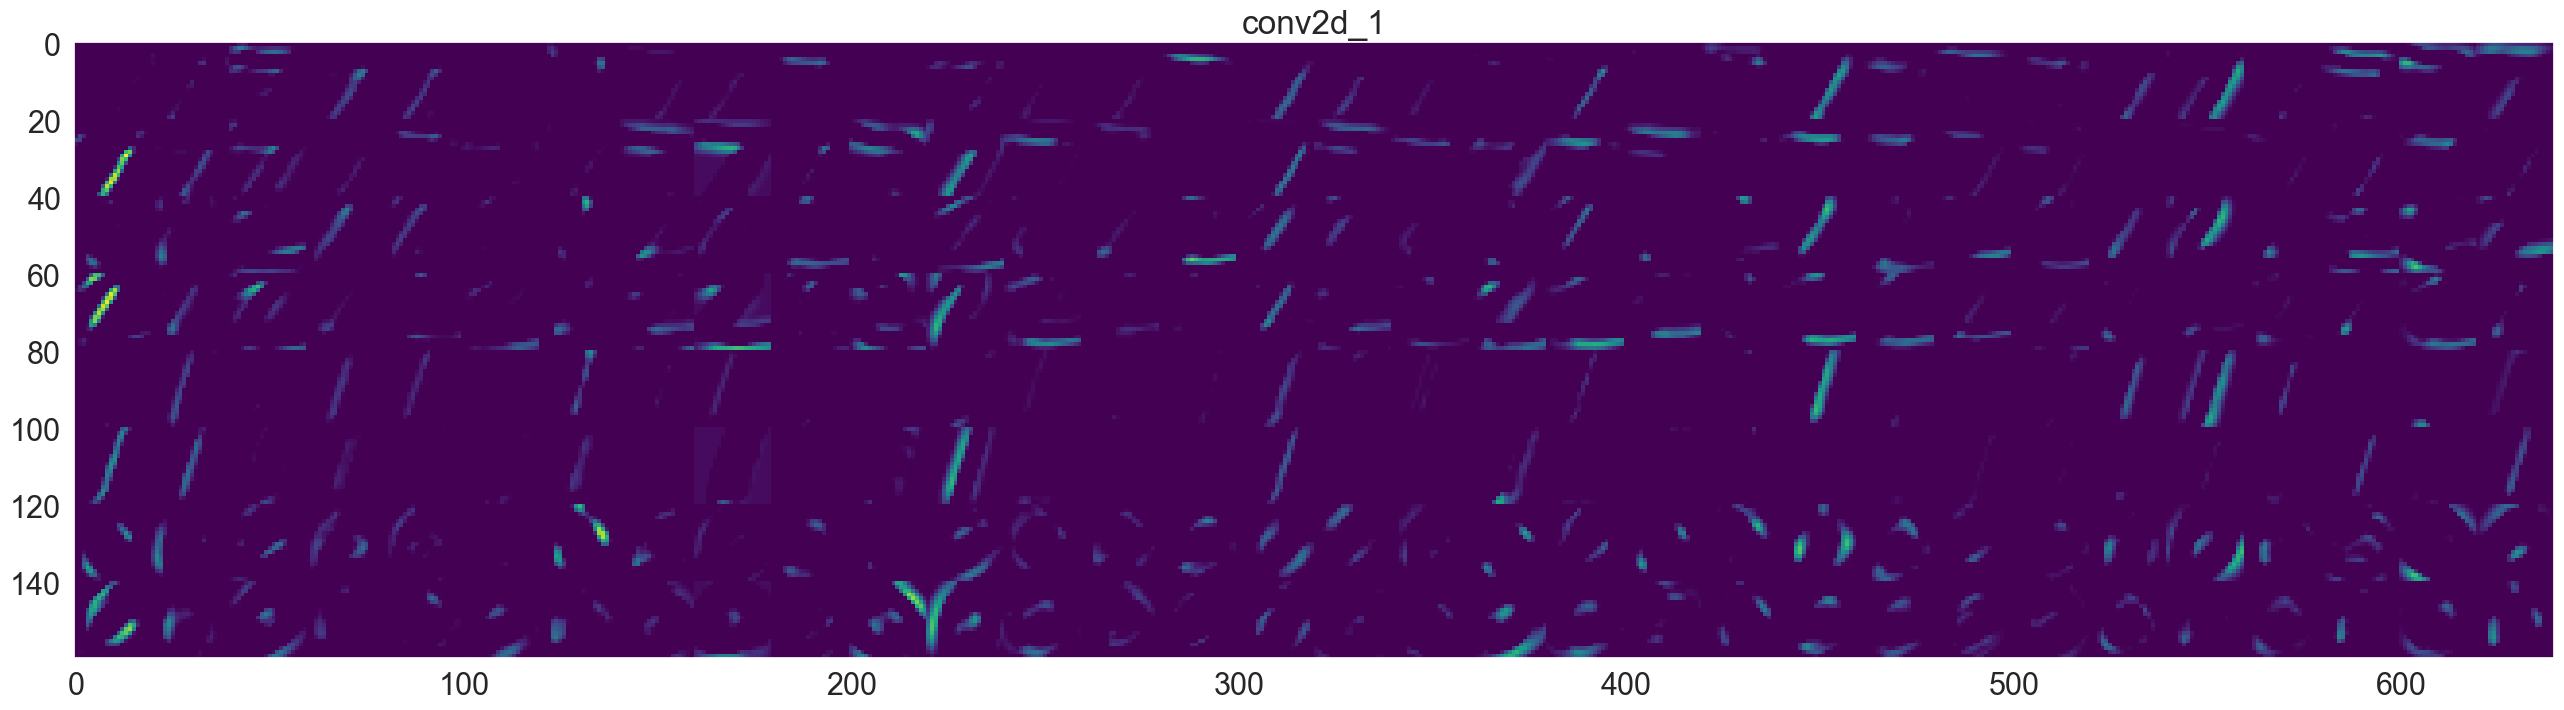

In [ ]:
# we won't go through this one, check link 5 below for explanation.
activations = activation_model.predict(img)
layer_names = []
for layer in model.layers[0:2]:
    layer_names.append(layer.name)
images_per_row = 32
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    ns= layer_activation.shape[0]
    display_grid = np.zeros((size * n_cols*ns, images_per_row * size))
    for s in range(ns):
      for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[s,
                                             :, :,
                                             col * images_per_row + row]    
            if False:                                             
              channel_image -= channel_image.mean() 
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[(col) * size+ size * n_cols*s: (col + 1) * size+ size * n_cols*s, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

References / Further reading:

1. https://adventuresinmachinelearning.com/neural-networks-tutorial/
2. https://adventuresinmachinelearning.com/python-tensorflow-tutorial/
3. https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/
4. Recommende for HW: http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
5. https://towardsdatascience.com/visualizing-intermediate-activations-of-a-cnn-trained-on-the-mnist-dataset-2c34426416c8